# DOS-卷积神经网络

In [1]:
import numpy as np
import pickle
import time
import argparse
import sys

# keras/sklearn libraries
import keras
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Input, Reshape, BatchNormalization
from keras.layers import (
    Conv1D,
    GlobalAveragePooling1D,
    MaxPooling1D,
    GlobalAveragePooling1D,
    Reshape,
    AveragePooling1D,
    Flatten,
    Concatenate,
)
from keras import backend
from keras.callbacks import TensorBoard, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn import model_selection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dos_para = pd.read_csv('../data/substituted_benzene_para_dos.csv',index_col=0,header=0)
dos_orth = pd.read_csv('../data/substituted_benzene_orth_dos.csv',index_col=0,header=0)
dos_meta = pd.read_csv('../data/substituted_benzene_meta_dos.csv',index_col=0,header=0)
dosdata = pd.concat([dos_meta,dos_orth,dos_para],axis=0,join='inner',ignore_index=True)

gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv',index_col=0,header=0)
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv',index_col=0,header=0)
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv',index_col=0,header=0)
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [4]:
def dfclean(data):
    temp = data[data.T[data.dtypes!=np.object].index]
    kk=[]
    for column in temp.columns:
        if len(set(temp[column]))<4:
            kk.append(column)
    result = temp.drop(columns=kk)
    return temp

In [5]:
rawdataset = pd.merge(dosdata, gammadata, on='cindex')
dataset = dfclean(rawdataset)

In [6]:
from sklearn.impute import SimpleImputer
dataset = SimpleImputer().fit_transform(dataset)

In [7]:
x = dataset[:, 1:-1]
#x = np.array(x, dtype = np.float64)
y = dataset[:, -1]
#y = np.array(y, dtype = np.float64)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)
# 3 训练数据和测试数据进行标准化处理
ss_x = StandardScaler()
X_train = ss_x.fit_transform(x_train)
X_test = ss_x.transform(x_test)

ss_y = StandardScaler()
Y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
Y_test = ss_y.transform(y_test.reshape(-1, 1))


x_train.shape: (270, 2970)
x_test.shape: (90, 2970)
y_train.shape: (270,)
y_test.shape: (90,)


In [18]:
###Each input represents one out of three possible bonding atoms
input1 = Input(shape=(2970,))


convmerge = Flatten()(input1)
convmerge = Dropout(0.5)(convmerge)
convmerge = Dense(300, activation="linear")(convmerge)
#convmerge = Dense(1500, activation="relu")(convmerge)
convmerge = Dense(1000, activation="relu")(convmerge)

out = Dense(1, activation="linear")(convmerge)
# shared_conv.summary()
model = Model(inputs = input1, outputs=out)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2970)]            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2970)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2970)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               891300    
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              301000    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1001      
Total params: 1,193,301
Trainable params: 1,193,301
Non-trainable params: 0
_________________________________________________

In [19]:
#model.compile(loss = 'mean_squared_error', optimizer = 'SGD'(lr = 0.001, momentum = 0.9, nesterov = True),metrics=['accuracy'])
model.compile(
                loss="logcosh", optimizer=Adam(0.0001), metrics=["mean_absolute_error"])
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 32,validation_data = (X_test, Y_test),verbose=1)
score = model.evaluate(X_test, Y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
Y_pred = model.predict(X_test)
rms = (np.mean((Y_test - Y_pred) ** 2)) ** 0.5
print("Neural Network RMS", rms)

Epoch 1/100
9/9 [==============================] - 1s 29ms/step - loss: 0.4658 - mean_absolute_error: 0.8714 - val_loss: 0.1856 - val_mean_absolute_error: 0.4821
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 0.2303 - mean_absolute_error: 0.5566 - val_loss: 0.1646 - val_mean_absolute_error: 0.4779
Epoch 3/100
9/9 [==============================] - 0s 12ms/step - loss: 0.1751 - mean_absolute_error: 0.4951 - val_loss: 0.1617 - val_mean_absolute_error: 0.4681
Epoch 4/100
9/9 [==============================] - 0s 11ms/step - loss: 0.1446 - mean_absolute_error: 0.4570 - val_loss: 0.1290 - val_mean_absolute_error: 0.4123
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.2019 - mean_absolute_error: 0.533 - 0s 11ms/step - loss: 0.1484 - mean_absolute_error: 0.4547 - val_loss: 0.1184 - val_mean_absolute_error: 0.3850
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 0.1507 - mean_absolute_error: 0.4445 - val_loss: 0.1069 - val_me

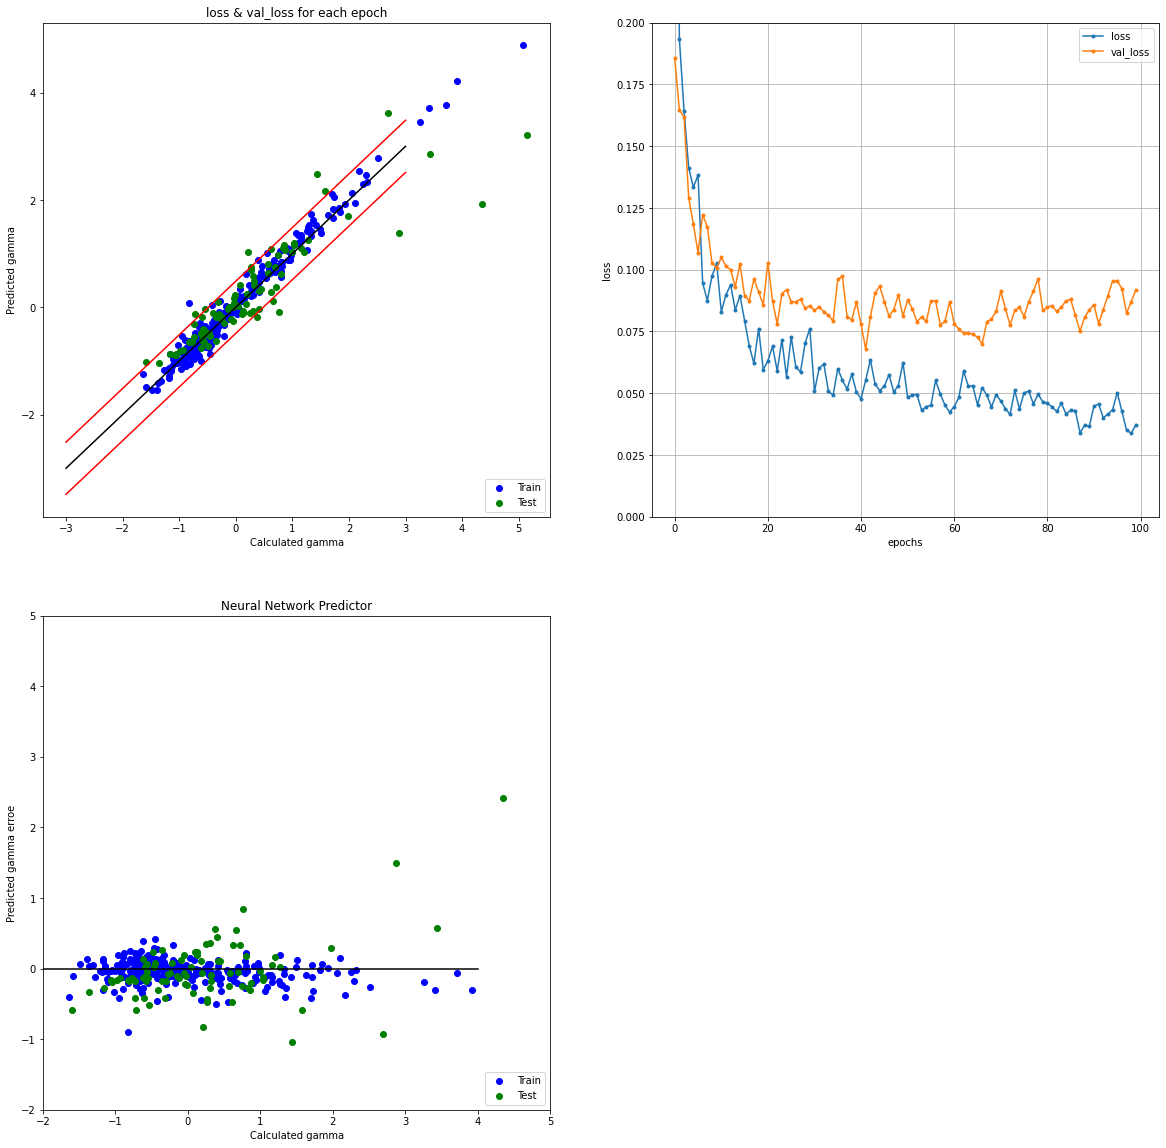

In [22]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(221)
ax1.set_title('Neural Network Predictor')
ax1.set_xlabel('Calculated gamma')
ax1.set_ylabel('Predicted gamma')
#ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax1.scatter(Y_train, model.predict(X_train), label = 'Train', c = 'blue')
ax1.scatter(Y_test, model.predict(X_test),c='green', label = 'Test', alpha = None)
ax1.plot([-3,3],[-3,3],c = 'k')
plt.plot([-3,3],[-3+rms,3+rms],c = 'r')
plt.plot([-3,3],[-3-rms,3-rms],c = 'r')
ax1.legend(loc = 4)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)

ax2 = fig.add_subplot(222)
ax1.set_title('loss & val_loss for each epoch')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.set_ylim(0,0.2)
ax2.plot(range(epochs), loss, marker = '.', label = 'loss')
ax2.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
ax2.legend(loc = 'best')
ax2.grid()

ax3 = fig.add_subplot(223)
ax3.set_title('Neural Network Predictor')
ax3.set_xlabel('Calculated gamma')
ax3.set_ylabel('Predicted gamma erroe')
ax3.set_xlim(-2,5)
ax3.set_ylim(-2,5)
ax3.scatter(Y_train,Y_train-model.predict(X_train), label = 'Train', c = 'blue')
ax3.scatter(Y_test,Y_test-model.predict(X_test),c='green', label = 'Test', alpha = None)
ax3.plot([-2,4],[0,0],c = 'k')
ax3.legend(loc = 4)

plt.show()

这个有点偏高，可以中和一下

holy shit 卷积网络这么牛逼的吗？